In [1]:
from pathlib import Path
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = 10, 6

from eval_distance import infer_matrices, infer_embeddings

In [2]:
def rocs(model_path: Path, distance_fn: str, subsample=2500):
    dist_matrix, mask_matrix, _ = infer_matrices(model_path, distance_fn)
    y_true  = mask_matrix.flatten()
    y_score = dist_matrix.flatten()

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    fpr = fpr[::subsample]
    tpr = tpr[::subsample]

    return fpr, tpr, auc_score

def dists(model_path: Path, distance_fn: str, subsample=2500):
    dist_matrix, mask_matrix, _ = infer_matrices(model_path, distance_fn)
    matching = dist_matrix[mask_matrix == 0].flatten()
    not_matching = dist_matrix[mask_matrix == 1].flatten()
    df_1 = pd.DataFrame({"distance": matching, "match_state": "match"})
    df_2 = pd.DataFrame({"distance": not_matching, "match_state": "no_match"})
    df = pd.concat((df_1, df_2))
    return df

    # plt.ylim((0, 0.4))
    # plt.xlim((0, 55))

In [3]:
paths = list(Path('./ckpts/class').rglob("*.pth"))

named_paths = dict()
for p in paths:
    if '.bin' in str(p):
        named_paths['bin'] = p
    elif '.full' in str(p):
        named_paths['full'] = p
    if '.ter' in str(p):
        named_paths['ter'] = p

print([f"{n}: {p.as_posix()}" for n, p in named_paths.items()])

['bin: ckpts/class/bin/best.bin.pth', 'full: ckpts/class/full/best.full.pth', 'ter: ckpts/class/ter/best.ter.pth']


In [54]:
res_rocs = dict()

for n, p in named_paths.items():
    print('/n', n)
    res_rocs[n] = rocs(p, distance_fn="euc")

/n bin
num of classes:  118
num samples: 3740
loading model: bin


inference: 100%|██████████| 15/15 [00:00<00:00, 40.41it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...
/n full
num of classes:  118
num samples: 3740
loading model: full


inference: 100%|██████████| 15/15 [00:00<00:00, 38.79it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...
/n ter
num of classes:  118
num samples: 3740
loading model: ter
model init parameteres (fron dict): {'layer_inflation': 1, 'f32_activations': False, 'dropout': 0, 'delta': 0.3}
loaded delta: 0.3


inference: 100%|██████████| 15/15 [00:00<00:00, 28.99it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...


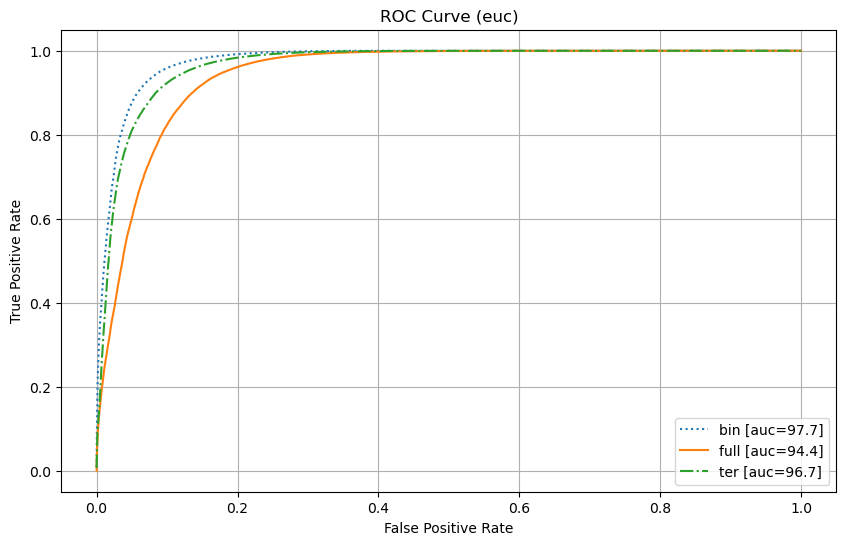

In [74]:
for model_name, (fpr, tpr, auc_score) in res_rocs.items():
    label = f"{model_name} [auc={auc_score*100:.1f}]"
    linestyle = dict(bin="dotted", full="solid", ter='dashdot')[model_name]
    sns.lineplot(x=np.append(fpr, 1.0), y=np.append(tpr, 1.0), label=label, linestyle=linestyle)
plt.title(f"ROC Curve (euc)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate");
plt.grid()

In [58]:
dists_res = dict()

for n, p in named_paths.items():
    print('/n', n)
    dists_res[n] = dists(p, distance_fn="euc")

/n bin
num of classes:  118
num samples: 3740
loading model: bin


inference: 100%|██████████| 15/15 [00:00<00:00, 40.48it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...
/n full
num of classes:  118
num samples: 3740
loading model: full


inference: 100%|██████████| 15/15 [00:00<00:00, 39.18it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...
/n ter
num of classes:  118
num samples: 3740
loading model: ter
model init parameteres (fron dict): {'layer_inflation': 1, 'f32_activations': False, 'dropout': 0, 'delta': 0.3}
loaded delta: 0.3


inference: 100%|██████████| 15/15 [00:00<00:00, 31.23it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...


Text(0.5, 0, 'Distance (euc)')

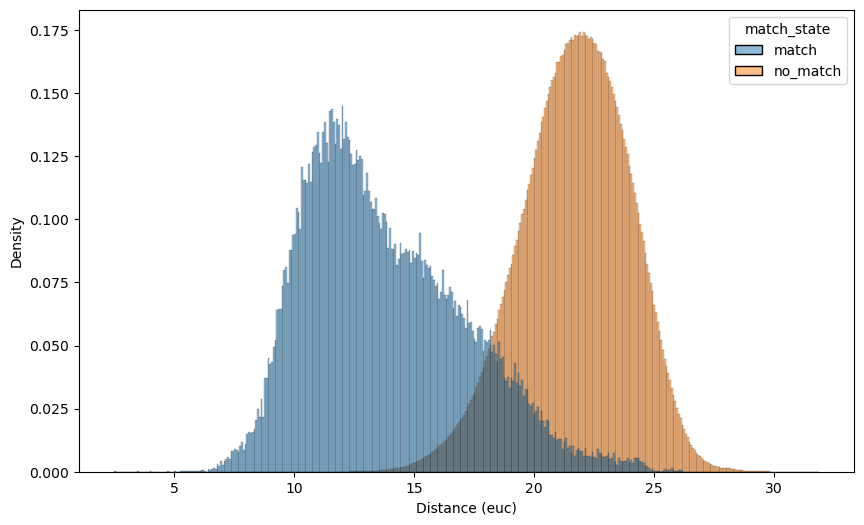

In [70]:
df = dists_res['ter']
sns.histplot(df[df['distance'] > 0], x="distance", hue="match_state", stat="density", common_norm=False, bins=400)
plt.xlabel("Distance (euc)")

In [4]:
all_paths = [('class', n, p) for n, p in named_paths.items()]

paths = Path('ckpts/triplet/euc/').rglob("*.pth")

for p in paths:
    if '.bin' in str(p):
        model_name = 'bin'
    elif '.full' in str(p):
        model_name = 'full'
    elif '.ter' in str(p):
        model_name = 'ter'

    all_paths.append(('triplet(euc)', model_name, p))

paths = Path('ckpts/triplet-os/euc/').rglob("*.pth")

for p in paths:
    if '.bin' in str(p):
        model_name = 'bin'
    elif '.full' in str(p):
        model_name = 'full'
    elif '.ter' in str(p):
        model_name = 'ter'

    all_paths.append(('triplet[os](euc)', model_name, p))

for t in all_paths:
    print(t)

('class', 'bin', WindowsPath('ckpts/class/bin/best.bin.pth'))
('class', 'full', WindowsPath('ckpts/class/full/best.full.pth'))
('class', 'ter', WindowsPath('ckpts/class/ter/best.ter.pth'))
('triplet(euc)', 'bin', WindowsPath('ckpts/triplet/euc/model=bin_epochs=100_lr=0.01_bs=256_margin=1.5_dist=euc/best.bin.pth'))
('triplet(euc)', 'full', WindowsPath('ckpts/triplet/euc/model=full_epochs=100_lr=0.001_bs=256_margin=10.0_dist=euc/best.full.pth'))
('triplet(euc)', 'ter', WindowsPath('ckpts/triplet/euc/model=ter_epochs=100_lr=0.01_bs=256_margin=1.5_dist=euc_dreg=log_dmin=0_dmaxep=20_dmax=0.2/best.ter.pth'))
('triplet[os](euc)', 'bin', WindowsPath('ckpts/triplet-os/euc/model=bin_epochs=100_lr=0.01_bs=128_margin=5.0_dist=euc_open=0/best.bin.pth'))
('triplet[os](euc)', 'full', WindowsPath('ckpts/triplet-os/euc/model=full_epochs=100_lr=0.001_bs=256_margin=5.0_dist=euc_open=0/best.full.pth'))
('triplet[os](euc)', 'ter', WindowsPath('ckpts/triplet-os/euc/model=ter_epochs=100_lr=0.01_bs=256_margin

In [5]:
res2_rocs = list()
dist_type = "euc"

for k, v, p in all_paths:
    print('\n', k, v)
    res2_rocs.append( (k, v, rocs(p, distance_fn=dist_type)) )


 class bin
num of classes:  118
num samples: 3740
loading model: bin


inference: 100%|██████████| 15/15 [00:00<00:00, 36.72it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...

 class full
num of classes:  118
num samples: 3740
loading model: full


inference: 100%|██████████| 15/15 [00:00<00:00, 39.88it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...

 class ter
model init parameteres (fron dict): {'layer_inflation': 1, 'f32_activations': False, 'dropout': 0, 'delta': 0.3}
num of classes:  118
num samples: 3740
loading model: ter
loaded delta: 0.3


inference: 100%|██████████| 15/15 [00:00<00:00, 28.95it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...

 triplet(euc) bin
num of classes:  118
num samples: 3740
loading model: bin


inference: 100%|██████████| 15/15 [00:00<00:00, 39.31it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...

 triplet(euc) full
num of classes:  118
num samples: 3740
loading model: full


inference: 100%|██████████| 15/15 [00:00<00:00, 39.37it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...

 triplet(euc) ter
model init parameteres (fron dict): {'delta': 0.2}
num of classes:  118
num samples: 3740
loading model: ter
loaded delta: 0.2


inference: 100%|██████████| 15/15 [00:00<00:00, 28.81it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...

 triplet[os](euc) bin
model init parameteres (fron dict): {}
doing open set on split num: 0
test labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
num of classes:  118
num samples: 3922
loading model: bin


inference: 100%|██████████| 16/16 [00:00<00:00, 40.01it/s]


embeddings shape: (3922, 2048) - labels shape: (3922,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...

 triplet[os](euc) full
model init parameteres (fron dict): {}
doing open set on split num: 0
test labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
num of classes:  118
num samples: 3922
loading model: full


inference: 100%|██████████| 16/16 [00:00<00:00, 37.80it/s]


embeddings shape: (3922, 2048) - labels shape: (3922,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...

 triplet[os](euc) ter
model init parameteres (fron dict): {'delta': 0.2}
doing open set on split num: 0
test labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
num of classes:  118
num samples: 3922
loading model: ter
loaded delta: 0.2


inference: 100%|██████████| 16/16 [00:00<00:00, 29.51it/s]


embeddings shape: (3922, 2048) - labels shape: (3922,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...


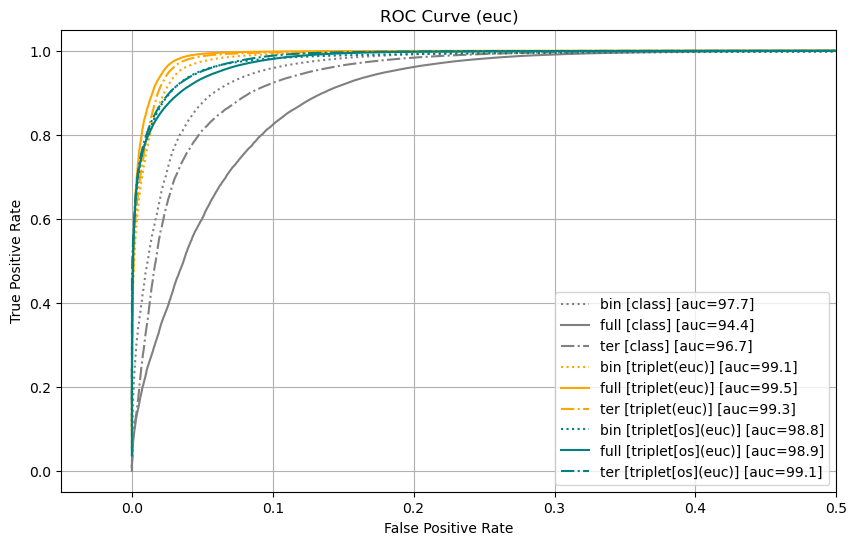

In [11]:
for training, model, (fpr, tpr, roc_auc) in res2_rocs:
    label = f"{model} [{training}] [auc={roc_auc*100:.1f}]"
    linestyle = dict(bin="dotted", full="solid", ter='dashdot')[model]
    color = {'class': 'gray', 'triplet(euc)': 'orange', 'triplet[os](euc)': 'teal'}[training]
    sns.lineplot(x=np.append(fpr, 1.0), y=np.append(tpr, 1.0), label=label, linestyle=linestyle, color=color)
plt.title(f"ROC Curve ({dist_type})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate");
plt.xlim(right=0.5)
plt.grid()

In [86]:
res2_dists = list()
dist_type = "euc"

for k, v, p in all_paths:
    print('\n', k, v)
    res2_dists.append( (k, v, dists(p, distance_fn=dist_type)) )


 class bin
num of classes:  118
num samples: 3740
loading model: bin


inference: 100%|██████████| 15/15 [00:00<00:00, 39.83it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...

 class full
num of classes:  118
num samples: 3740
loading model: full


inference: 100%|██████████| 15/15 [00:00<00:00, 38.76it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...

 class ter
num of classes:  118
num samples: 3740
loading model: ter
model init parameteres (fron dict): {'layer_inflation': 1, 'f32_activations': False, 'dropout': 0, 'delta': 0.3}
loaded delta: 0.3


inference: 100%|██████████| 15/15 [00:00<00:00, 30.17it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...

 triplet(euc) bin
num of classes:  118
num samples: 3740
loading model: bin


inference: 100%|██████████| 15/15 [00:00<00:00, 40.73it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...

 triplet(euc) full
num of classes:  118
num samples: 3740
loading model: full


inference: 100%|██████████| 15/15 [00:00<00:00, 40.97it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...

 triplet(euc) ter
num of classes:  118
num samples: 3740
loading model: ter
model init parameteres (fron dict): {'delta': 0.2}
loaded delta: 0.2


inference: 100%|██████████| 15/15 [00:00<00:00, 29.36it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
generating class, mask matrix...
generating dist matrix (euc, quantize=False)...


bin
full
ter


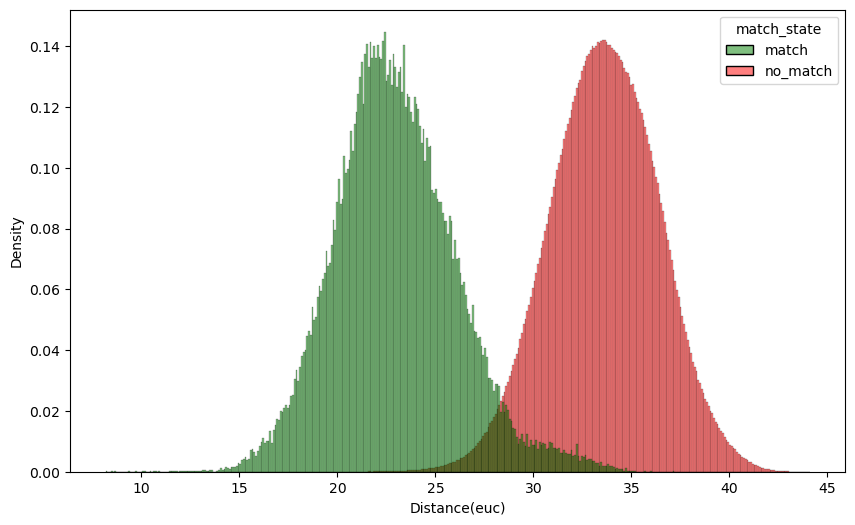

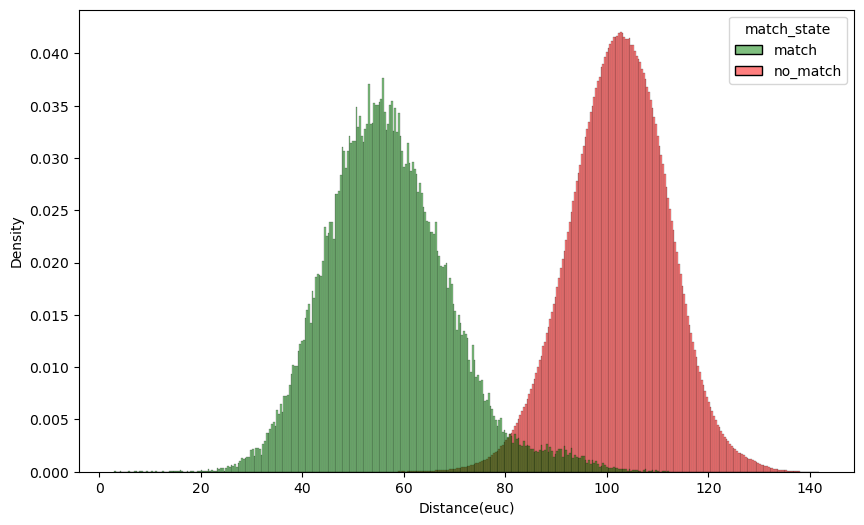

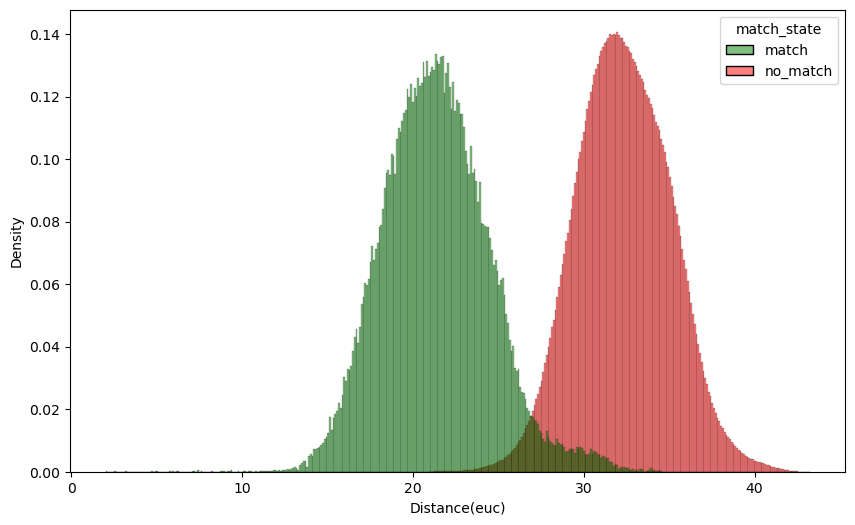

In [95]:
for training, model, df in res2_dists:
    if training == 'class': continue
    print(model)
    plt.figure()
    sns.histplot(df[df['distance'] > 0], x="distance", hue="match_state", stat="density", common_norm=False, bins=400, palette=("green", "red"))
    plt.xlabel(f"Distance({dist_type})")
    # break

In [100]:
def tsne(model_path: Path):
    print(">> generating tsne for model: ", model_path)

    X_test, y_test = infer_embeddings(model_path, train_ds=False)
    print("shapes:", X_test.shape, y_test.shape)

    # subset = y_test < 100 # first 10 classes
    # X_test = X_test[subset]
    # y_test = y_test[subset]

    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
    return tsne.fit_transform(X_test), y_test


In [101]:
res2_tsne = list()

for k, v, p in all_paths:
    print('\n', k, v)
    res2_tsne.append( (k, v, tsne(p)) )


 class bin
>> generating tsne for model:  ckpts\class\bin\best.bin.pth
num of classes:  118
num samples: 3740
loading model: bin


inference: 100%|██████████| 15/15 [00:00<00:00, 41.22it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
shapes: (3740, 2048) (3740,)

 class full
>> generating tsne for model:  ckpts\class\full\best.full.pth
num of classes:  118
num samples: 3740
loading model: full


inference: 100%|██████████| 15/15 [00:00<00:00, 38.96it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
shapes: (3740, 2048) (3740,)

 class ter
>> generating tsne for model:  ckpts\class\ter\best.ter.pth
num of classes:  118
num samples: 3740
loading model: ter
model init parameteres (fron dict): {'layer_inflation': 1, 'f32_activations': False, 'dropout': 0, 'delta': 0.3}
loaded delta: 0.3


inference: 100%|██████████| 15/15 [00:00<00:00, 28.44it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
shapes: (3740, 2048) (3740,)

 triplet(euc) bin
>> generating tsne for model:  ckpts\triplet\euc\model=bin_epochs=100_lr=0.01_bs=256_margin=1.5_dist=euc\best.bin.pth
num of classes:  118
num samples: 3740
loading model: bin


inference: 100%|██████████| 15/15 [00:00<00:00, 38.98it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
shapes: (3740, 2048) (3740,)

 triplet(euc) full
>> generating tsne for model:  ckpts\triplet\euc\model=full_epochs=100_lr=0.001_bs=256_margin=10.0_dist=euc\best.full.pth
num of classes:  118
num samples: 3740
loading model: full


inference: 100%|██████████| 15/15 [00:00<00:00, 40.00it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
shapes: (3740, 2048) (3740,)

 triplet(euc) ter
>> generating tsne for model:  ckpts\triplet\euc\model=ter_epochs=100_lr=0.01_bs=256_margin=1.5_dist=euc_dreg=log_dmin=0_dmaxep=20_dmax=0.2\best.ter.pth
num of classes:  118
num samples: 3740
loading model: ter
model init parameteres (fron dict): {'delta': 0.2}
loaded delta: 0.2


inference: 100%|██████████| 15/15 [00:00<00:00, 29.46it/s]


embeddings shape: (3740, 2048) - labels shape: (3740,)
shapes: (3740, 2048) (3740,)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\giaco\\Dev\\gyro-classifier\\padova\\src\\~\\Pictures\\tsne-class-bin.png'

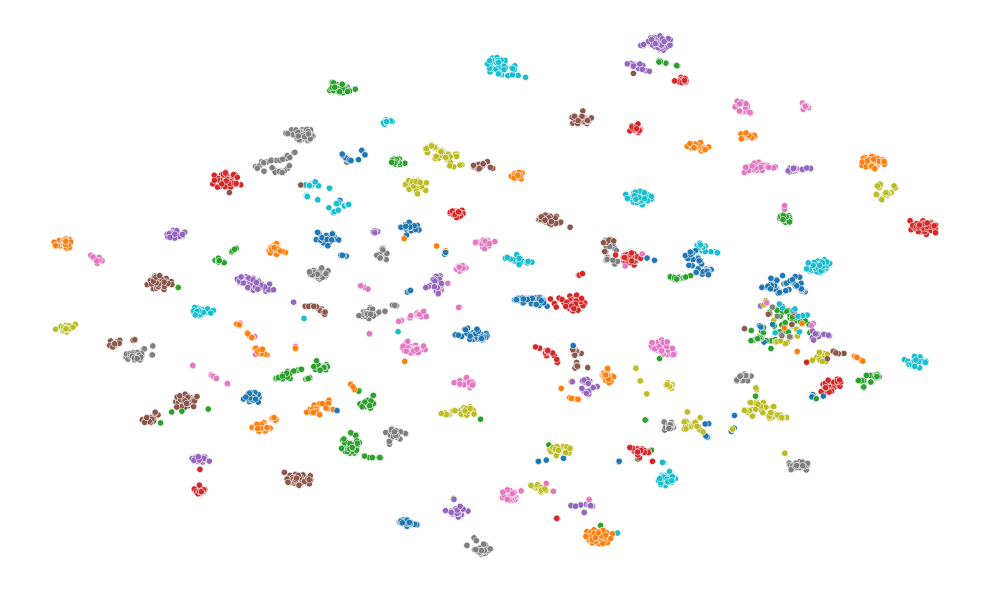

In [115]:
for training, model, (X, y) in res2_tsne:
    plt.figure()
    ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y.astype(int), s=20, palette='tab10', legend=False)
    # plt.scatter(X[:, 0], X[:, 1], c=y.astype(int), cmap='tab10', s=3)
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(f"./figs/tsne-{training}-{model}")
    
    # plt.legend(*scatter.legend_elements(), title="person")



In [15]:
import json

res_path = 'logs-triplet/open-set-results.jsonl'
with open(res_path, 'r') as f:
    rows = [json.loads(line) for line in f.readlines()]

df = pd.DataFrame(rows)
df

,dist,model,hp,split,roc_euc,roc_cos,roc_hamm,silh,rand,rand_adj
0,euc,bin,model=bin_epochs=1_lr=0.01_bs=256_margin=1.5_d...,0,0.947674,0.954677,0.954729,0.126656,0.977797,0.864756
1,euc,bin,model=bin_epochs=1_lr=0.01_bs=256_margin=1.5_d...,1,0.988025,0.985826,0.982937,0.139615,0.978527,0.870967


In [16]:
cols = [col for col in df.columns if col not in ['hp', 'split']]
df[cols].groupby(['dist', 'model']).mean()

,,roc_euc,roc_cos,roc_hamm,silh,rand,rand_adj
dist,model,,,,,,
euc,bin,0.96785,0.970252,0.968833,0.133135,0.978162,0.867862
